Chinese stopwords: https://github.com/stopwords-iso/stopwords-zh

# Using `stanza` on Weibo posts

This notebooks demonstrates some of the features of the NLP package `stanza`: https://stanfordnlp.github.io/stanza/pipeline.html 

The notebooks uses the Weibo posts from December 2019 about COVID-19: https://github.com/nghuyong/weibo-public-opinion-datasets 

## Packages and installing chinese language model

For this notebook, `pandas`, `seaborn` and `stanza` is used.

`stanza` has a series of language models: https://stanfordnlp.github.io/stanza/available_models.html 

These can be downloaded using `stanza.download()`. After downloading, the model can be used in a NLP pipeline.

In [36]:
import pandas as pd # For data handling
import seaborn as sns # For visualization
import stanza # For NLP
import numpy as np # Arithmetic operations

stanza.download('zh') # Downloads the language model

## Loading the data

Data is loaded as a pandas dataframe:

In [37]:
weibo_df = pd.read_csv("C:/Users/kgk/OneDrive - Aalborg Universitet/CALDISS_projects/digital-literacy_E20/text-networks/data/2019-12.csv")

weibo_df.head()

,_id,crawl_time,created_at,like_num,repost_num,comment_num,content,origin_weibo,location_map_info
0,IiF4ShXQZ,1587604890,2019-12-01 00:00:17,1,0,0,《药品管理法》《疫苗管理法》👏👏,NaN,NaN
1,IiF5S5tKi,1587968450,2019-12-01 00:02:44,1,0,0,[微风]今日 周六 大风 第三天 打疫苗 实测体重2.6公斤,NaN,NaN
2,IiF6Zcfr3,1587968119,2019-12-01 00:05:29,0,0,0,明天新的《中华人民共和国药品管理法》和《疫苗管理法》就实行了。 友情提醒：虽然第九十八条把...,IiEEaDOkW,NaN
3,IiF75FUT4,1587895953,2019-12-01 00:05:45,0,0,0,持续不断否定自己 变得一点信心也没有 对自己否定 对生活否定 对一切都怀疑 今天压力真的大到...,NaN,NaN
4,IiF84inVj,1587964711,2019-12-01 00:08:09,0,0,0,央视新闻频道，正在播出宇芽家暴的专题采访。 这个专题之前是高以翔事件的报道。 转发理由:看...,IiEBvb90s,NaN


### Subsetting the data

The data set is pretty massive, so running the tokenization and sentiment analysis will take a while on a standard laptop or computer.

Therefore this notebook used a random sample of 500 posts, filtered by length (less than 100 characters) and by having between 1 and 100 likes:

In [168]:
weibo_subset = weibo_df.loc[(weibo_df['like_num'] >= 1) & (weibo_df['like_num'] <= 100), :].reset_index(drop = True)
weibo_subset = weibo_subset.loc[weibo_df['content'].apply(len) < 100, :].reset_index(drop = True)
weibo_subset = weibo_subset.sample(n = 500, replace = False, random_state = 42).reset_index(drop = True)

weibo_subset.head() # First five rows of the subset

,_id,crawl_time,created_at,like_num,repost_num,comment_num,content,origin_weibo,location_map_info
0,IkIL376XG,1588026389,2019-12-14 13:03:02,1,0,0,#南通白癜风医院[超话]# 孩子患上白癜风家长怎么办？家长能够仔细观察下孩子脸上的白斑是否...,NaN,NaN
1,IiXSzwDxU,1587921195,2019-12-02 23:52:09,1,0,0,【#中方宣布制裁美部分非政府组织# 转！必须付出代价！】日前，美方不顾中方坚决反对，执意将所...,IiUws06Cm,NaN
2,IiUafymhb,1587929010,2019-12-02 14:24:43,1,0,0,【愿早日康复！#贵州悬崖小学前校长患白血病#：曾牵学生走400米绝壁求学】徐良凡曾是贵州毕节...,IiTBkv9iq,NaN
3,IiUQEwpd7,1587999624,2019-12-02 16:09:12,2,0,0,【#中方宣布制裁美部分非政府组织# 转！必须付出代价！】日前，美方不顾中方坚决反对，执意将所...,IiUws06Cm,NaN
4,InjM2rDyS,1588007558,2019-12-31 14:57:42,1,0,0,【农业农村部公布2019年#农业转基因生物安全证书批准清单#】农业农村部30日公布2019年...,InbgnmGqJ,NaN


In [169]:
weibo_subset.shape # Rows and columns of the subset

(500, 9)

**NOTE:** Even though data is subset to only consist of 500 posts, the parts of this notebook that tokenize and use sentiment analysis on all posts in the data set still takes a while on a normal laptop/computer!

## Tokenizing and POS-tagging

`stanza` works by converting a string to a `Document` object using a NLP pipeline.

**Pipeline**
A "pipeline" can be understood as the different operations and functions that will be used on the text (fx tokenization, POS-tagging, name-entity recognition). To speed up the process, it can make sense to specify what operations the pipeline should include (will include all by default).

**Processors**
The different operations and functions are refered to as "processors": https://stanfordnlp.github.io/stanza/pipeline.html

The tokenizer processor in `stanza` segments a text into "sentences", each containing a list of tokens/words. The sentiment processor works on a `sentence` in a text. 

The POS processor labels the individual words with their POS tags.



### Tokenizing Weibo data using stanza

To use `stanza` for tokenizing, first define the pipeline to include the relevant processors (here `tokenize` and `sentiment`):

In [170]:
nlp = stanza.Pipeline('zh', processors='tokenize,pos')

2020-12-01 14:00:06 INFO: "zh" is an alias for "zh-hans"
2020-12-01 14:00:06 INFO: Loading these models for language: zh-hans (Simplified_Chinese):
| Processor | Package |
-----------------------
| tokenize  | gsdsimp |
| pos       | gsdsimp |

2020-12-01 14:00:06 INFO: Use device: cpu
2020-12-01 14:00:06 INFO: Loading: tokenize
2020-12-01 14:00:06 INFO: Loading: pos
2020-12-01 14:00:09 INFO: Done loading processors!


With the pipeline defined, it is ready to be used on a string/post. Here it is used on the 21st post of the subset using `.loc[]` (index 20, because indexes start at 0).

In [183]:
doc = nlp(weibo_subset.loc[20, 'content'])

Because the tokenizer processor segments text into sentences, these have to be iterated over to extract all the tokens.

The individual `word` objects in the sentences contains various attributes (the attributes depend on the pipeline). 

The attribute `word.text` contains the actual token.

In [184]:
tokens = []

for sentence in doc.sentences:
    for word in sentence.words:
        tokens.append(word.text)

print(tokens)

['#', '武汉', '发现', '不明', '原', '因', '肺炎', '#', '在', '四', '号', '线', '上', '戴', '着', '口罩', '要', '被', '闷死', '但', '又', '不敢', '不带']


### POS tagging

The POS processor adds a POS tag as an attribute to each word in the document object.

Just to demonstrate, the tokens are here printed along with their POS tag for the first post:

In [185]:
for sentence in doc.sentences:
    for word in sentence.words:
        print(word.text + ", " + word.pos)

#, ADP
武汉, PROPN
发现, VERB
不明, ADJ
原, ADV
因, ADP
肺炎, NOUN
#, PUNCT
在, VERB
四, NUM
号, NOUN
线, PART
上, ADP
戴, VERB
着, PART
口罩, NOUN
要, AUX
被, VERB
闷死, VERB
但, ADV
又, ADV
不敢, VERB
不带, PUNCT


The model is not perfect and some errors are apparent. In this example, the "#" is tagged as ADP (adposition).

### Filtering tokens using POS

To filter tokens based on POS, a list of POS tags can be defined to check the individual tags against, to only include specific POS tags.

In the code below the previous operations are combined into a function including POS tags to check. The function the works on a single string/post:

In [186]:
def tokenizer_custom(text):
    doc = nlp(text)
    
    pos_tags = ['PROPN', 'ADJ', 'NOUN'] # Keeps proper nouns, adjectives and nouns
    
    tokens = []
      
    for sentence in doc.sentences:
        for word in sentence.words:
            if word.pos in pos_tags:
                tokens.append(word.text)
    
    return(tokens)

In [187]:
tokenizer_custom(weibo_subset.loc[20, 'content'])

['武汉', '不明', '肺炎', '号', '口罩']

### Adding filtered tokens as a variable/column to the data

To add the filtered tokens as a variable in the data, apply the function to every post in the data using `.apply()`:

In [188]:
weibo_subset['tokens_filtered'] = weibo_subset['content'].apply(tokenizer_custom)

In [189]:
weibo_subset.head()

,_id,crawl_time,created_at,like_num,repost_num,comment_num,content,origin_weibo,location_map_info,tokens_filtered
0,IkIL376XG,1588026389,2019-12-14 13:03:02,1,0,0,#南通白癜风医院[超话]# 孩子患上白癜风家长怎么办？家长能够仔细观察下孩子脸上的白斑是否...,NaN,NaN,"[#南, 通白, 癜风, 医院, ], 孩子, 白癜, 风家, 家长, 观察, 孩子, 脸上..."
1,IiXSzwDxU,1587921195,2019-12-02 23:52:09,1,0,0,【#中方宣布制裁美部分非政府组织# 转！必须付出代价！】日前，美方不顾中方坚决反对，执意将所...,IiUws06Cm,NaN,"[中方, 美, 部分, 政府, 组织, 代价, 美, 中方, 香港, 人权, 民主, 法案,..."
2,IiUafymhb,1587929010,2019-12-02 14:24:43,1,0,0,【愿早日康复！#贵州悬崖小学前校长患白血病#：曾牵学生走400米绝壁求学】徐良凡曾是贵州毕节...,IiTBkv9iq,NaN,"[早日, 贵州, 悬崖, 小学, 前校, 长患, 白血, 病#, 米, 绝壁, 徐, 良凡,..."
3,IiUQEwpd7,1587999624,2019-12-02 16:09:12,2,0,0,【#中方宣布制裁美部分非政府组织# 转！必须付出代价！】日前，美方不顾中方坚决反对，执意将所...,IiUws06Cm,NaN,"[中方, 美, 部分, 政府, 组织, 代价, 美, 中方, 香港, 人权, 民主, 法案,..."
4,InjM2rDyS,1588007558,2019-12-31 14:57:42,1,0,0,【农业农村部公布2019年#农业转基因生物安全证书批准清单#】农业农村部30日公布2019年...,InbgnmGqJ,NaN,"[农业, 农村, 年, 农业, 转基, 生物, 安全, 证书, 清单, 农业, 农村, 日,..."


## Sentiment analysis

`stanza` has a built in "Sentimentprocessor" for performing sentiment analysis on text.

From the documentation: "The `SentimentProcessor` adds a label for sentiment to each `Sentence`. The existing models each support negative, neutral, and positive, represented by 0, 1, 2 respectively" (https://stanfordnlp.github.io/stanza/sentiment.html)

To use it, first define the pipeline to include the sentiment processor (this overwrites the previous pipeline):

In [190]:
nlp = stanza.Pipeline('zh', processors='tokenize,sentiment')

2020-12-01 14:03:22 INFO: "zh" is an alias for "zh-hans"
2020-12-01 14:03:22 INFO: Loading these models for language: zh-hans (Simplified_Chinese):
| Processor | Package |
-----------------------
| tokenize  | gsdsimp |
| sentiment | ren     |

2020-12-01 14:03:22 INFO: Use device: cpu
2020-12-01 14:03:22 INFO: Loading: tokenize
2020-12-01 14:03:22 INFO: Loading: sentiment
2020-12-01 14:03:25 INFO: Done loading processors!


New pipeline being used on the first post of the subset:

In [193]:
doc = nlp(weibo_subset.loc[30, 'content'])

Because the processor adds a sentiment label to each sentence, one post will contain several sentiment scores:

In [194]:
for sentence in doc.sentences:
    print(sentence.text + ", " + str(sentence.sentiment))

温度又直逼39度[生病][允悲]药到病没除啊！, 0
什么时候才能退烧，乖乖睡觉了，希望明天不要再烧了，整个人发抖了，一直喊冷，开了空调盖了两床被子[晕]还是冷，多少年没这样发烧了，明年十月带他接种流感疫苗去 宁波·宁波鄞州万达广场 显示地图, 2


According to this stanza language model, the first sentence of this post is categorized as "negative" and the second sentence as positive.

To get an idea of the sentiment in a post, a function can be defined to calculate the mean sentiment of the sentences in the post/text:

In [195]:
def mean_sentiment(text):
    doc = nlp(text)
    
    mean_sentiment = np.mean([sentence.sentiment for sentence in doc.sentences])
    
    return(mean_sentiment)

In [196]:
mean_sentiment(weibo_subset.loc[30, 'content'])

1.0

(Calculating the sentiment this way could be critizied. This way of calculating does fx not account for the length of sentences.)

The function can then be used to create a `sentiment` variable using the `.apply()` method in pandas:

In [197]:
weibo_subset['sentiment'] = weibo_subset['content'].apply(mean_sentiment)

In [198]:
weibo_subset.head()

,_id,crawl_time,created_at,like_num,repost_num,comment_num,content,origin_weibo,location_map_info,tokens_filtered,sentiment
0,IkIL376XG,1588026389,2019-12-14 13:03:02,1,0,0,#南通白癜风医院[超话]# 孩子患上白癜风家长怎么办？家长能够仔细观察下孩子脸上的白斑是否...,NaN,NaN,"[#南, 通白, 癜风, 医院, ], 孩子, 白癜, 风家, 家长, 观察, 孩子, 脸上...",0.833333
1,IiXSzwDxU,1587921195,2019-12-02 23:52:09,1,0,0,【#中方宣布制裁美部分非政府组织# 转！必须付出代价！】日前，美方不顾中方坚决反对，执意将所...,IiUws06Cm,NaN,"[中方, 美, 部分, 政府, 组织, 代价, 美, 中方, 香港, 人权, 民主, 法案,...",1.000000
2,IiUafymhb,1587929010,2019-12-02 14:24:43,1,0,0,【愿早日康复！#贵州悬崖小学前校长患白血病#：曾牵学生走400米绝壁求学】徐良凡曾是贵州毕节...,IiTBkv9iq,NaN,"[早日, 贵州, 悬崖, 小学, 前校, 长患, 白血, 病#, 米, 绝壁, 徐, 良凡,...",1.333333
3,IiUQEwpd7,1587999624,2019-12-02 16:09:12,2,0,0,【#中方宣布制裁美部分非政府组织# 转！必须付出代价！】日前，美方不顾中方坚决反对，执意将所...,IiUws06Cm,NaN,"[中方, 美, 部分, 政府, 组织, 代价, 美, 中方, 香港, 人权, 民主, 法案,...",1.000000
4,InjM2rDyS,1588007558,2019-12-31 14:57:42,1,0,0,【农业农村部公布2019年#农业转基因生物安全证书批准清单#】农业农村部30日公布2019年...,InbgnmGqJ,NaN,"[农业, 农村, 年, 农业, 转基, 生物, 安全, 证书, 清单, 农业, 农村, 日,...",0.600000


## Visualizing

An added benefit of pandas dataframes is that it is relatively easy to visualize. 

In the code below, `seaborn` is used to create a scatterplot of the posts on a data axis and number of likes axis, coloured by sentiment (only on the subset of 500 posts, however):

In [199]:
weibo_subset['created_at'] = pd.to_datetime(weibo_subset['created_at']) # This code converts the variable/column to a date variable/column

To make the scatterplot easier to read, only posts with less that 50 likes are kept:

In [202]:
weibo_subset_filtered = weibo_subset.loc[weibo_subset['like_num'] < 50, :]

<AxesSubplot:xlabel='created_at', ylabel='like_num'>

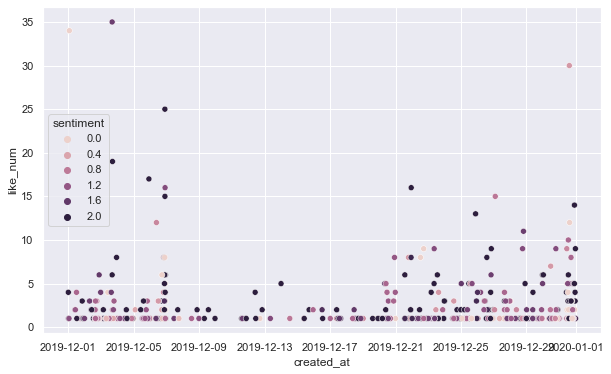

In [203]:
sns.set(rc={'figure.figsize':(10,6)}) # This line defines the default size of plots when printed in a notebook

sns.scatterplot(data = weibo_subset_filtered, x = 'created_at', y = 'like_num', hue = 'sentiment')

### Summarizing by dates or weeks

An interesting feature of working with dates and pandas is that it is easy to summarize data by month, week, year or so on.

In the code below, a column is created to reflect the week number the post was posted. The data is then grouped by the week (meaning data is split into groups based on the individual week values). Based on the grouped data, the mean sentiment score is calculated on a weekly basis.

In [205]:
weibo_subset['post_week'] = weibo_subset['created_at'].dt.isocalendar().week

weibo_grouped = weibo_subset.groupby('post_week')

weibo_grouped['sentiment'].mean()

post_week
1     1.141357
48    1.315360
49    1.210541
50    1.595551
51    1.355976
52    1.338646
Name: sentiment, dtype: float64

The same can be done with dates (here visualized):

<AxesSubplot:xlabel='post_date', ylabel='sentiment'>

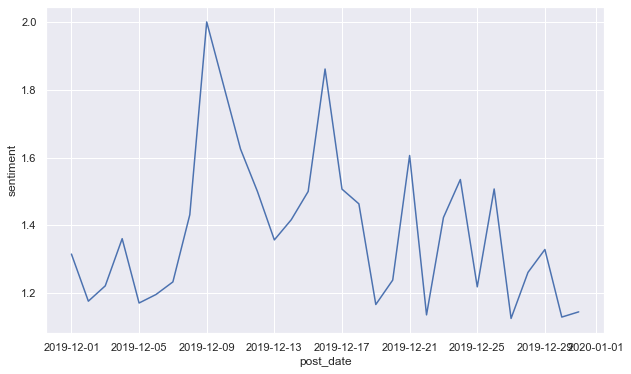

In [211]:
weibo_subset['post_date'] = weibo_subset['created_at'].dt.date
weibo_grouped_dates = weibo_subset.groupby('post_date')
weibo_date_sent = weibo_grouped_dates['sentiment'].mean().reset_index()

sns.lineplot(data = weibo_date_sent, x = "post_date", y = "sentiment")